In [76]:
import json
import os

# Define the JSON file path
PARAMS_FILE = "./input/user_parameters.json"

def load_parameters():
    """Loads parameters from the JSON file."""
    if os.path.exists(PARAMS_FILE):
        with open(PARAMS_FILE, "r") as f:
            return json.load(f)
    return {}

# Load the parameters
params = load_parameters()

# Check if augment_bathymetry is enabled
augment_bathymetry = params.get('augment_bathymetry', False)

# Print relevant message based on the value
if augment_bathymetry:
    print("Augment Bathymetry is ENABLED. Using NONNA and GEBCO data if available.")
else:
    print("Augment Bathymetry is DISABLED. No external bathymetric augmentation will be applied.")

# Example: Print all parameters
print(json.dumps(params, indent=4))

#Initialisation of boolean parameters for augmented bathymetry
nonna10_data_exist = False
nonna100_data_exist = False
geboco_data_exist = False

Augment Bathymetry is DISABLED. No external bathymetric augmentation will be applied.
{
    "user_bathymetry": "Combine_Arviat_HBlock_10m.tiff",
    "output_land_dir": "./output/Land_Features/",
    "output_chart_dir": "./output/Chart_Features/",
    "augment_bathymetry": false,
    "contour_list": [
        0,
        10,
        20,
        30,
        50,
        100
    ],
    "scale": 50000,
    "start_radius": 100.0,
    "end_radius": 450.0
}


In [77]:
import rasterio
import geopandas as gpd
from pyproj import Transformer
import numpy as np

# Define file paths
chart_limit_path = "./output/Chart_Features/chartlimit_utm.geojson"
bathymetry_tif_path = "./output/Bathymetric_Features/reprojected_bathymetry.tif"

# Load chart limit bounds
def get_chart_limit_bounds():
    """Loads the chart limit polygon and retrieves its bounds (min_x, min_y, max_x, max_y)."""
    try:
        gdf = gpd.read_file(chart_limit_path)
        return gdf.total_bounds if not gdf.empty else None
    except Exception as e:
        print(f"Error reading chart limit file: {e}")
        return None

# Load projected coordinate system from bathymetry.tif
try:
    ds = rasterio.open(bathymetry_tif_path)
    projected_coord_system = ds.crs  # Assign the CRS here!
    print(f"Projected Coordinate System: {projected_coord_system}")
    ds.close()
except Exception as e:
    print(f"Error reading bathymetry TIFF file: {e}")
    projected_coord_system = None

# Convert bounds to EPSG:3857 or EPSG:4326
def convert_bounds(bounds, src_crs, target_epsg):
    """Converts bounding box coordinates from src_crs to the given EPSG."""
    try:
        transformer = Transformer.from_crs(src_crs, f"EPSG:{target_epsg}", always_xy=True)
        return transformer.transform(bounds[0], bounds[1]) + transformer.transform(bounds[2], bounds[3])
    except Exception as e:
        print(f"Error transforming bounds to EPSG:{target_epsg}: {e}")
        return None

# Get chart limit bounds
chart_limit_bounds = get_chart_limit_bounds()

# Convert bounds to different coordinate systems
bounds_3857 = convert_bounds(chart_limit_bounds, projected_coord_system, 3857)
bounds_4326 = convert_bounds(chart_limit_bounds, projected_coord_system, 4326)

print(f"Chart Limit Bounds ({projected_coord_system}): {chart_limit_bounds}")
print(f"Converted Bounds (EPSG:3857): {bounds_3857}")
print(f"Converted Bounds (EPSG:4326): {bounds_4326}")

print(f"NoData value: {rasterio.open(bathymetry_tif_path).nodata}")

Projected Coordinate System: EPSG:32615
Chart Limit Bounds (EPSG:32615): [ 441199.  6774690.8  450611.  6781929.2]
Converted Bounds (EPSG:3857): (-10474132.102772046, 8649389.399863504, -10454909.998650031, 8664671.638542265)
Converted Bounds (EPSG:4326): (-94.09072955807072, 61.10246789140987, -93.91805445881329, 61.16873947033946)
NoData value: 3.4028234663852886e+38


In [78]:
### RECEIVE NONNA 10 FOR THE CHART LIMIT

import requests
import rasterio
import numpy as np

# WCS Service URL
WCS_URL = "https://nonna-geoserver.data.chs-shc.ca/geoserver/wcs?"
COVERAGE_ID = "nonna__NONNA 10 Coverage"  # Replace with actual layer
input_folder = "./input"

# Construct the WCS GetCoverage URL (Using EPSG:3857)
get_coverage_url = (
    f"{WCS_URL}service=WCS&request=GetCoverage&version=2.0.1"
    f"&coverageId={COVERAGE_ID}&format=image/tiff"
    f"&subset=x({bounds_3857[0]},{bounds_3857[2]})&"
    f"subset=y({bounds_3857[1]},{bounds_3857[3]})"
    f"&crs=EPSG:3857"
)

print("Updated GetCoverage URL:", get_coverage_url)

# Make the request
response = requests.get(get_coverage_url, stream=True)
tiff_path = f"{input_folder}/bathymetry_nonna_10_3857.tif"

if response.status_code == 200 and "image/tiff" in response.headers.get("Content-Type", ""):
    with open(tiff_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"WCS dataset successfully downloaded as {tiff_path}")

    # Step 2: Open and Analyze Raster for Data/NoData Pixels
    with rasterio.open(tiff_path) as dataset:
        raster_data = dataset.read(1)  # Read first band
        nodata_value = dataset.nodata

        # Count Data and NoData pixels
        nodata_count = np.sum(raster_data == nodata_value) if nodata_value is not None else 0
        data_count = raster_data.size - nodata_count

        print(f"Total Pixels: {raster_data.size}")
        print(f"Data Pixels: {data_count}")
        print(f"NoData Pixels: {nodata_count}")

        # If all pixels are NoData, set nonna10_data_exist to False
        if data_count > 0:
            nonna10_data_exist = True
else:
    print(f"WCS request failed: {response.text}")

print(f"NoData value: {rasterio.open(tiff_path).nodata}")

print(f"nonna10_data_exist: {nonna10_data_exist}")


Updated GetCoverage URL: https://nonna-geoserver.data.chs-shc.ca/geoserver/wcs?service=WCS&request=GetCoverage&version=2.0.1&coverageId=nonna__NONNA 10 Coverage&format=image/tiff&subset=x(-10474132.102772046,-10454909.998650031)&subset=y(8649389.399863504,8664671.638542265)&crs=EPSG:3857
WCS dataset successfully downloaded as ./input/bathymetry_nonna_10_3857.tif
Total Pixels: 803794
Data Pixels: 24772
NoData Pixels: 779022
NoData value: 3.4028234663852886e+38
nonna10_data_exist: True


== NoData Counts Before Processing ==
Raster: ./output/Bathymetric_Features/reprojected_bathymetry.tif | NoData Pixels: 646340
Raster: ./input/bathymetry_nonna_10_3857.tif | NoData Pixels: 779022
Reprojected raster saved at: ./output/Bathymetric_Features/reprojected_3857_to_match.tif
Merged raster with buffer saved as: ./output/Bathymetric_Features/merged_bathymetry_10.tif

== Merged Raster Statistics ==
Band 1 - Min: -14.722999572753906, Max: 2.6570000648498535, Mean: -2.5478715896606445, Std: 2.5852134227752686
Band 2 - Min: 1.0, Max: 2.0, Mean: 1.0901291370391846, Std: 0.28636667132377625
NoData value: 3.4028234663852886e+38


/opt/miniconda3/lib/python3.12/site-packages/matplotlib/image.py:513: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


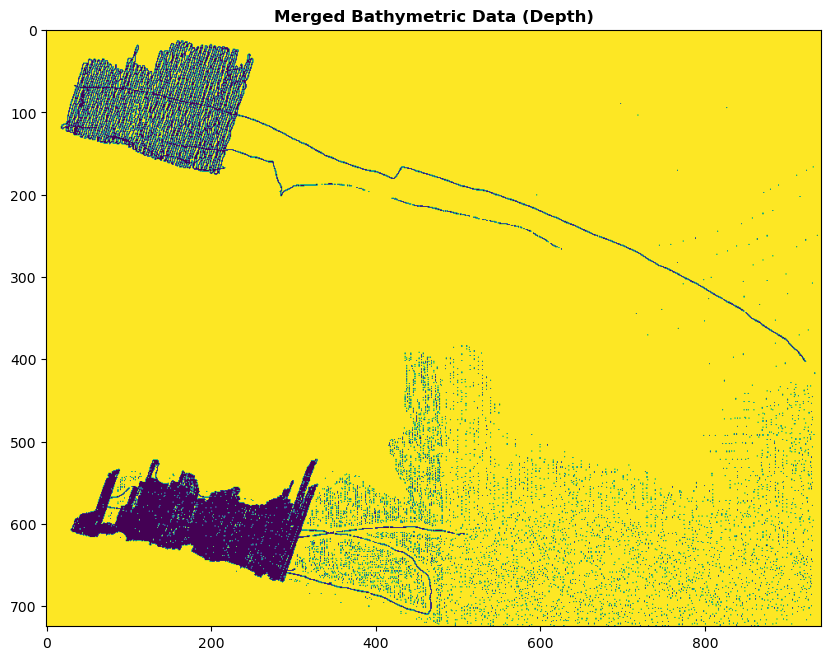

In [79]:
### REPROJECT NONNA 10 AND MERGE WITH USER BATHYMETRY - NEW CODE WITH BUFFER

if not nonna10_data_exist:
    print("Skipping raster processing and mapping as nonna10_data_exist is False.")
else:
    import rasterio
    from rasterio.warp import Resampling
    from rasterio.vrt import WarpedVRT
    import numpy as np
    import os
    from scipy.ndimage import binary_dilation
    import matplotlib.pyplot as plt
    from rasterio.plot import show

    # Define input files
    input_tif1 = "./input/bathymetry_nonna_10_3857.tif"  # NONNA 10
    input_tif2 = "./output/Bathymetric_Features/reprojected_bathymetry.tif"  # USER Bathymetry

    # Define output files
    reprojected_tif = "./output/Bathymetric_Features/reprojected_3857_to_match.tif"
    output_merged_tif = "./output/Bathymetric_Features/merged_bathymetry_10.tif"

    def reproject_large_raster(input_tif, reference_tif, output_tif):
        """Efficiently reprojects a large raster using virtual datasets (VRT) and chunk processing."""
        with rasterio.open(reference_tif) as ref:
            ref_crs = ref.crs
            ref_transform = ref.transform
            ref_width, ref_height = ref.width, ref.height

            # Open input raster in a virtual warped dataset (streaming reprojection)
            with rasterio.open(input_tif) as src:
                with WarpedVRT(src, crs=ref_crs, transform=ref_transform,
                               width=ref_width, height=ref_height,
                               resampling=Resampling.bilinear) as vrt:

                    # Copy metadata from reference dataset
                    vrt_meta = ref.meta.copy()
                    vrt_meta.update({
                        "driver": "GTiff",
                        "width": ref_width,
                        "height": ref_height,
                        "crs": ref_crs,
                        "transform": ref_transform
                    })

                    # Write out the reprojected data chunk-by-chunk
                    with rasterio.open(output_tif, "w", **vrt_meta) as dst:
                        for _, window in ref.block_windows(1):  # Process in small blocks
                            data = vrt.read(1, window=window)
                            dst.write(data, window=window, indexes=1)

        print(f"Reprojected raster saved at: {output_tif}")
        return output_tif

    def compute_nodata_count(raster_path):
        """Computes the count of NoData pixels in a raster."""
        with rasterio.open(raster_path) as src:
            nodata_value = src.nodata
            if nodata_value is None:
                print(f"Warning: NoData value not set in {raster_path}")
                return 0
            data = src.read(1)
            nodata_count = np.sum(data == nodata_value)
            print(f"Raster: {raster_path} | NoData Pixels: {nodata_count}")
            return nodata_count

    def compute_statistics(raster_path):
        """Computes statistics (min, max, mean, std) for each band in the raster."""
        with rasterio.open(raster_path) as src:
            stats = {}
            nodata_value = src.nodata
            for band in range(1, src.count + 1):
                data = src.read(band)

                # Exclude NoData values
                valid_data = data[data != nodata_value] if nodata_value is not None else data
                valid_data = valid_data[np.isfinite(valid_data)]  # Remove NaN/Inf

                if valid_data.size > 0:
                    stats[band] = {
                        "min": np.min(valid_data),
                        "max": np.max(valid_data),
                        "mean": np.mean(valid_data),
                        "std": np.std(valid_data)
                    }
                else:
                    stats[band] = {"min": None, "max": None, "mean": None, "std": None}

            return stats

    def create_buffer_mask(user_tif, buffer_pixels=5):
        """Creates a buffer mask around valid user bathymetry data."""
        with rasterio.open(user_tif) as src:
            nodata_value = src.nodata
            valid_data = src.read(1)

            # Create binary mask: 1 where user data is valid, 0 otherwise
            data_mask = valid_data != nodata_value

            # Apply dilation to create the buffer zone
            buffer_mask = binary_dilation(data_mask, iterations=buffer_pixels)

            return buffer_mask

    def merge_rasters_with_buffer(user_tif, nonna_tif, output_tif, buffer_pixels=5):
        """Merges rasters while ensuring NONNA 10 does not overwrite the user data buffer zone."""
        with rasterio.open(user_tif) as src_user, rasterio.open(nonna_tif) as src_nonna:
            nodata_value = src_user.nodata if src_user.nodata is not None else -9999

            meta = src_user.meta.copy()
            meta.update({"count": 2, "nodata": nodata_value, "dtype": "float32"})

            # Generate the buffer mask
            buffer_mask = create_buffer_mask(user_tif, buffer_pixels)

            with rasterio.open(output_tif, "w", **meta) as dst:
                for _, window in src_user.block_windows(1):
                    user_data = src_user.read(1, window=window)
                    nonna_data = src_nonna.read(1, window=window)

                    # Valid pixel masks
                    user_valid = user_data != nodata_value
                    nonna_valid = nonna_data != nodata_value

                    # Load the corresponding buffer window
                    buffer_window = buffer_mask[window.row_off:window.row_off+window.height,
                                                window.col_off:window.col_off+window.width]

                    # Ensure NONNA 10 is excluded from the buffer area
                    nonna_valid[buffer_window] = False  

                    # Merge Data: USER has priority, NONNA 10 fills gaps outside buffer
                    merged_data = np.where(user_valid, user_data, np.where(nonna_valid, nonna_data, nodata_value))

                    # Source Band: Track origin
                    source_band = np.full_like(merged_data, nodata_value, dtype=np.float32)
                    source_band[user_valid] = 1  # USER
                    source_band[nonna_valid & ~user_valid] = 2  # NONNA 10
                    source_band[buffer_window & ~user_valid] = 1  # BUFFER REGION

                    dst.write(merged_data, indexes=1, window=window)
                    dst.write(source_band, indexes=2, window=window)

        print(f"Merged raster with buffer saved as: {output_tif}")

    # Step 1: Compute NoData counts before processing
    print("== NoData Counts Before Processing ==")
    user_nodata_count = compute_nodata_count(input_tif2)
    nonna_nodata_count = compute_nodata_count(input_tif1)

    # Step 2: Reproject NONNA 10 to match USER bathymetry
    input_tif1_reprojected = reproject_large_raster(input_tif1, input_tif2, reprojected_tif)

    # Step 3: Merge while respecting buffer
    merge_rasters_with_buffer(input_tif2, reprojected_tif, output_merged_tif, buffer_pixels=5)

    # Step 4: Compute statistics on the merged raster
    print("\n== Merged Raster Statistics ==")
    merged_stats = compute_statistics(output_merged_tif)
    for band, stats in merged_stats.items():
        print(f"Band {band} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")

    print(f"NoData value: {rasterio.open(output_merged_tif).nodata}")
    
    # Step 5: Display merged raster
    fig, ax = plt.subplots(figsize=(10, 10))
    with rasterio.open(output_merged_tif) as merged_src:
        show(merged_src.read(1), ax=ax, title="Merged Bathymetric Data (Depth)")
    plt.show()


In [80]:
# NONNA 100 Bathymetric Data Retrieval Script
#
# This script requests a bathymetric dataset (NONNA 100) from a Web Coverage Service (WCS) 
# based on a user-defined bounding box. The retrieved raster dataset is analyzed for 
# valid depth data, and the presence of bathymetric information is determined.
#
# Inputs:
#   - WCS_URL: The base URL of the WCS service providing the NONNA 100 dataset.
#   - COVERAGE_ID: The unique identifier for the requested coverage/layer.
#   - bounds_3857: The bounding box coordinates in EPSG:3857 (Web Mercator).
#   - input_folder: The directory where the downloaded TIFF file is saved.
#
# Outputs:
#   - A GeoTIFF file containing the requested bathymetric data.
#   - Console logs indicating success or failure of the data retrieval.
#   - Information on valid data vs. NoData pixels.
#   - A boolean flag (`nonna100_data_exist`) indicating whether valid bathymetric data was retrieved.
#
# Method:
#   - Constructs a WCS **GetCoverage** request using the user’s bounding box.
#   - Sends an HTTP request to retrieve the dataset.
#   - Saves the raster dataset as a **GeoTIFF** file.
#   - Reads the raster file to analyze the number of **valid** and **NoData** pixels.
#   - If all pixels are NoData, sets `nonna100_data_exist = False`.
#
# Dependencies:
#   - `requests` for making WCS requests.
#   - `rasterio` for reading and analyzing the raster dataset.
#   - `numpy` for pixel count calculations.

import requests
import rasterio
import numpy as np

# WCS Service URL
WCS_URL = "https://nonna-geoserver.data.chs-shc.ca/geoserver/wcs?"
COVERAGE_ID = "nonna__NONNA 100 Coverage"  # Replace with actual layer
input_folder = "./input"

# Construct the WCS GetCoverage URL (Using EPSG:3857)
get_coverage_url = (
    f"{WCS_URL}service=WCS&request=GetCoverage&version=2.0.1"
    f"&coverageId={COVERAGE_ID}&format=image/tiff"
    f"&subset=x({bounds_3857[0]},{bounds_3857[2]})&"
    f"subset=y({bounds_3857[1]},{bounds_3857[3]})"
    f"&crs=EPSG:3857"
)

print("Updated GetCoverage URL:", get_coverage_url)

# Make the request
response = requests.get(get_coverage_url, stream=True)
tiff_path = f"{input_folder}/bathymetry_nonna_100_3857.tif"

if response.status_code == 200 and "image/tiff" in response.headers.get("Content-Type", ""):
    with open(tiff_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"WCS dataset successfully downloaded as {tiff_path}")

    # Step 2: Open and Analyze Raster for Data/NoData Pixels
    with rasterio.open(tiff_path) as dataset:
        raster_data = dataset.read(1)  # Read first band
        nodata_value = dataset.nodata

        # Count Data and NoData pixels
        nodata_count = np.sum(raster_data == nodata_value) if nodata_value is not None else 0
        data_count = raster_data.size - nodata_count

        print(f"Total Pixels: {raster_data.size}")
        print(f"Data Pixels: {data_count}")
        print(f"NoData Pixels: {nodata_count}")
        
        # If all pixels are NoData, set nonna100_data_exist to False
        if data_count > 0:
            nonna100_data_exist = True
else:
    print(f"WCS request failed: {response.text}")

print(f"NoData value: {rasterio.open(tiff_path).nodata}")

print(f"nonna100_data_exist: {nonna100_data_exist}")

Updated GetCoverage URL: https://nonna-geoserver.data.chs-shc.ca/geoserver/wcs?service=WCS&request=GetCoverage&version=2.0.1&coverageId=nonna__NONNA 100 Coverage&format=image/tiff&subset=x(-10474132.102772046,-10454909.998650031)&subset=y(8649389.399863504,8664671.638542265)&crs=EPSG:3857
WCS dataset successfully downloaded as ./input/bathymetry_nonna_100_3857.tif
Total Pixels: 12600
Data Pixels: 4100
NoData Pixels: 8500
NoData value: 3.4028234663852886e+38
nonna100_data_exist: True


Reprojected raster saved at: ./output/Bathymetric_Features/reprojected_3857_100_to_match.tif
Merged raster with NONNA 100 saved as: ./output/Bathymetric_Features/merged_bathymetry_10_100.tif
Band 2 Source Tracking Statistics After Merging
Total Pixels: 682950
  USER: 73069 pixels (10.70%)
  NONNA 10: 263746 pixels (38.62%)
  NONNA 100: 1838 pixels (0.27%)
NoData Pixels: 344297 pixels (50.41%)


== Merged Raster Statistics ==
Band 1 - Min: -18.799999237060547, Max: 3.799999952316284, Mean: -2.5559134483337402, Std: 2.7949438095092773
Band 2 - Min: 1.0, Max: 3.0, Mean: 1.7896637916564941, Std: 0.42065390944480896
NoData value: 3.4028234663852886e+38


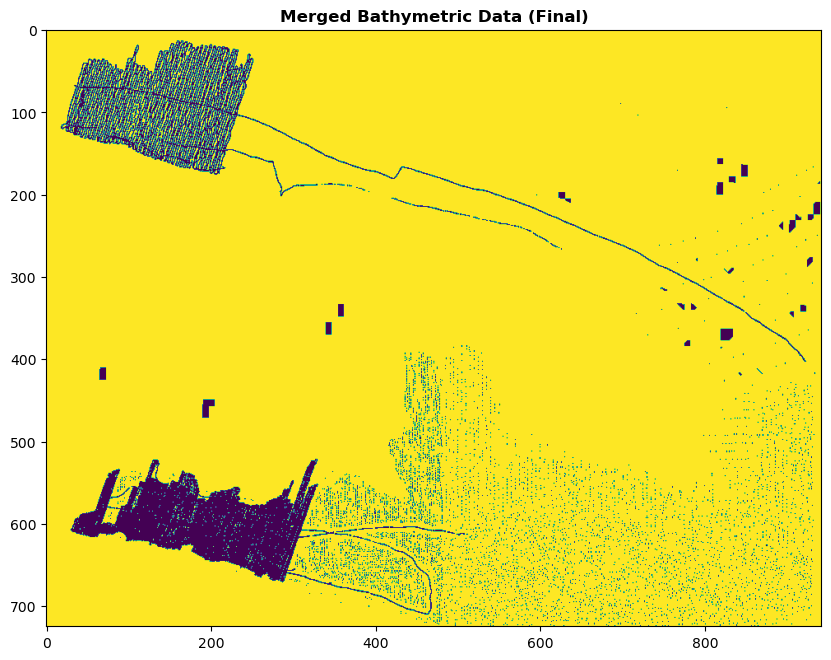

In [81]:
### REPROJECT NONNA 100 AND MERGE WITH USER BATHYMETRY + NONNA 10 - NEW CODE WITH BUFFER
if not nonna100_data_exist:
    print("Skipping raster processing and mapping as nonna100_data_exist is False.")
else:
    import rasterio
    import numpy as np
    import matplotlib.pyplot as plt
    from rasterio.plot import show
    from rasterio.warp import Resampling
    from rasterio.vrt import WarpedVRT
    from scipy.ndimage import binary_dilation
    import os

    # Define input files
    input_tif1 = "./input/bathymetry_nonna_100_3857.tif"  # NONNA 100
    input_tif2 = "./output/Bathymetric_Features/merged_bathymetry_10.tif"  # USER + NONNA 10

    # Define output files
    reprojected_tif = "./output/Bathymetric_Features/reprojected_3857_100_to_match.tif"
    output_merged_tif = "./output/Bathymetric_Features/merged_bathymetry_10_100.tif"

    def create_buffer_mask(raster_tif, buffer_pixels=25):
        """Creates a buffer mask around valid bathymetry data."""
        with rasterio.open(raster_tif) as src:
            nodata_value = src.nodata
            valid_data = src.read(1)

            # Create binary mask: 1 where user data is valid, 0 otherwise
            data_mask = valid_data != nodata_value

            # Apply dilation to create the buffer zone
            buffer_mask = binary_dilation(data_mask, iterations=buffer_pixels)

            return buffer_mask
    
    def merge_rasters_with_buffer(merged_user_nonna10_tif, nonna100_tif, output_tif, buffer_pixels=25):
        """
        Merges NONNA 100 onto an already merged USER + NONNA 10 raster.
        Ensures NONNA 100 does not overwrite the buffered region and retains existing pixel markings.
        Marks the new buffer as NONNA 10 (2).
        """
        with rasterio.open(merged_user_nonna10_tif) as src_merged, rasterio.open(nonna100_tif) as src_nonna100:
            nodata_value = src_merged.nodata if src_merged.nodata is not None else -9999

            meta = src_merged.meta.copy()
            meta.update({"count": 2, "nodata": nodata_value, "dtype": "float32"})

            # Generate the buffer mask
            buffer_mask = create_buffer_mask(merged_user_nonna10_tif, buffer_pixels)

            with rasterio.open(output_tif, "w", **meta) as dst:
                for _, window in src_merged.block_windows(1):
                    merged_data = src_merged.read(1, window=window)  # USER + NONNA 10 Data
                    nonna100_data = src_nonna100.read(1, window=window)  # NONNA 100 Data
    
                    # Try to read source band (Band 2), if missing initialize it
                    try:
                        source_band = src_merged.read(2, window=window)
                    except IndexError:
                        source_band = np.full_like(merged_data, nodata_value, dtype=np.float32)
    
                    # Valid pixel masks
                    user_valid = source_band == 1
                    nonna10_valid = source_band == 2
                    nonna100_valid = (nonna100_data != nodata_value) & ~(user_valid | nonna10_valid)
    
                    # Load the corresponding buffer window
                    buffer_window = buffer_mask[window.row_off:window.row_off+window.height,
                                                window.col_off:window.col_off+window.width]
    
                    # Ensure NONNA 100 does not overwrite marked pixels (User or NONNA 10)
                    nonna100_valid[buffer_window] = False  
    
                    # Merge Data: Keep existing merged data, fill with NONNA 100 where needed
                    final_data = np.where(user_valid | nonna10_valid, merged_data, 
                                 np.where(nonna100_valid, nonna100_data, nodata_value))
    
                    # Update Band 2: Keep original values, assign 3 for NONNA 100 where it applies,
                    # and mark the buffer region as NONNA 10 (2)
                    final_source_band = np.where(user_valid, 1, 
                                        np.where(nonna10_valid | buffer_window, 2, 
                                        np.where(nonna100_valid, 3, nodata_value)))
    
                    dst.write(final_data, indexes=1, window=window)
                    dst.write(final_source_band, indexes=2, window=window)
    
            print(f"Merged raster with NONNA 100 saved as: {output_tif}")

    def compute_band_2_statistics(raster_path):
        """Computes and prints statistics for Band 2, which tracks data sources."""
        with rasterio.open(raster_path) as src:
            if src.count < 2:
                print(f"Error: {raster_path} does not have a second band for source tracking.")
                return
            
            band_2 = src.read(2)  # Read Band 2 (source tracking)
            nodata_value = src.nodata

            # Count the number of pixels in each category
            unique_values, counts = np.unique(band_2[band_2 != nodata_value], return_counts=True)
            total_pixels = band_2.size

            print("Band 2 Source Tracking Statistics After Merging")
            print(f"Total Pixels: {total_pixels}")
            
            # Display counts for each source
            source_labels = {1: "USER", 2: "NONNA 10", 3: "NONNA 100"}
            for value, count in zip(unique_values, counts):
                label = source_labels.get(value, f"Unknown ({value})")
                percentage = (count / total_pixels) * 100
                print(f"  {label}: {count} pixels ({percentage:.2f}%)")

            # Count NoData pixels separately
            nodata_count = np.sum(band_2 == nodata_value)
            nodata_percentage = (nodata_count / total_pixels) * 100
            print(f"NoData Pixels: {nodata_count} pixels ({nodata_percentage:.2f}%)\n")

    def compute_statistics(raster_path):
        """Computes statistics (min, max, mean, std) for each band in the raster."""
        with rasterio.open(raster_path) as src:
            stats = {}
            nodata_value = src.nodata
            for band in range(1, src.count + 1):
                data = src.read(band)

                # Exclude NoData values
                valid_data = data[data != nodata_value] if nodata_value is not None else data
                valid_data = valid_data[np.isfinite(valid_data)]  # Remove NaN/Inf

                if valid_data.size > 0:
                    stats[band] = {
                        "min": np.min(valid_data),
                        "max": np.max(valid_data),
                        "mean": np.mean(valid_data),
                        "std": np.std(valid_data)
                    }
                else:
                    stats[band] = {"min": None, "max": None, "mean": None, "std": None}

            return stats
            
    # Step 1: Reproject NONNA 100 to match USER + NONNA 10
    input_tif1_reprojected = reproject_large_raster(input_tif1, input_tif2, reprojected_tif)

    # Step 2: Merge while respecting buffer
    merge_rasters_with_buffer(input_tif2, reprojected_tif, output_merged_tif, buffer_pixels=25)

    # Step 3: Verify Band 2 After Merging
    compute_band_2_statistics(output_merged_tif)

    # Step 4: Compute statistics on the merged raster
    print("\n== Merged Raster Statistics ==")
    merged_stats = compute_statistics(output_merged_tif)
    for band, stats in merged_stats.items():
        print(f"Band {band} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")

    print(f"NoData value: {rasterio.open(output_merged_tif).nodata}")
    
    # Step 4: Display merged raster
    fig, ax = plt.subplots(figsize=(10, 10))
    with rasterio.open(output_merged_tif) as merged_src:
        show(merged_src.read(1), ax=ax, title="Merged Bathymetric Data (Final)")
    plt.show()


In [ ]:
### RECEIVE GEBCO FOR THE USER BBOX

import requests
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import box
import os

# WCS Service URL and Layer Configuration
WCS_URL = ""
COVERAGE_ID = ""  # Replace with actual layer

# Construct the WCS GetCoverage URL using the bounding box
get_coverage_url = (
    f"{WCS_URL}service=WCS&request=GetCoverage&version=2.0.1"
    f"&coverageId={COVERAGE_ID}&format=image/tiff"
    f"&BBOX={bounds_4326[0]},{bounds_4326[1]},{bounds_4326[2]},{bounds_4326[3]}"
    f"&crs=EPSG:4326"
)

print("Updated GetCoverage URL:", get_coverage_url)

# Make the WCS request
response = requests.get(get_coverage_url, stream=True)

# Define paths for saving the raster data
output_path = "./input/bathymetry_gebco_2024_4326.tif"
clipped_path = "./input/bathymetry_gebco_2024_3857_clipped.tif"
gebco_data_exist = True  # Default flag, will be set to False if no valid data is found

# Verify response and save TIFF file
if response.status_code == 200 and "image/tiff" in response.headers.get("Content-Type", ""):
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"WCS dataset successfully downloaded as {output_path}")

    # Read and Analyze Raster File
    with rasterio.open(output_path) as src:
        dataset_bounds = src.bounds  # (min_x, min_y, max_x, max_y)
        raster_crs = src.crs
        print(f"Raster Loaded - CRS: {raster_crs}")
        print(f"Raster Bounds: {dataset_bounds}")

        # Check if the requested bounding box is within raster bounds
        request_box = box(*bounds_4326)
        dataset_box = box(dataset_bounds.left, dataset_bounds.bottom, dataset_bounds.right, dataset_bounds.top)

        print(f"Requested BBOX: {request_box.bounds}")
        print(f"Raster BBOX: {dataset_box.bounds}")

        if not request_box.intersects(dataset_box):  # Check if there is an overlap
            print("ERROR: Requested bounding box does not overlap with the raster data.")
            gebco_data_exist = False
            os.remove(output_path)  # Delete the faulty raster file
        else:
            print("Clipping response file to requested bounds...")

            # Convert bounding box to a GeoJSON-like dictionary for clipping
            bbox_geom = gpd.GeoDataFrame({"geometry": [request_box]}, crs="EPSG:4326")

            # Attempt to Clip Raster
            try:
                out_image, out_transform = rasterio.mask.mask(src, bbox_geom.geometry, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Save clipped raster
                with rasterio.open(clipped_path, "w", **out_meta) as dest:
                    dest.write(out_image)

                print(f"Clipped file saved as {clipped_path}")
                os.remove(output_path)  # Delete the original response file

                # Check if Clipped Raster is Empty
                with rasterio.open(clipped_path) as clipped_src:
                    max_value = clipped_src.read(1).max()
                    print(f"Max Value in Clipped Raster: {max_value}")

                    if max_value == 0:  # Check if all values are zero
                        print("Clipped file is empty, setting gebco_data_exist = False")
                        gebco_data_exist = False
                        os.remove(clipped_path)  # Delete the empty clipped file

            except Exception as e:
                print(f"ERROR while clipping: {e}")
                gebco_data_exist = False
                os.remove(output_path)  # Delete the faulty response file

else:
    print(f"WCS request failed: {response.text}")
    gebco_data_exist = False

print(f"NoData value: {rasterio.open(clipped_path).nodata}")

# Final Status
print(f"GEBCO Data Exists: {gebco_data_exist}")


Updated GetCoverage URL: https://geo.vps2.sail-charts.com/geoserver/wcs?service=WCS&request=GetCoverage&version=2.0.1&coverageId=csb__canada_gebco_2024_cog&format=image/tiff&BBOX=-94.09072955807072,61.10246789140987,-93.91805445881329,61.16873947033946&crs=EPSG:4326
WCS dataset successfully downloaded as ./input/bathymetry_gebco_2024_4326.tif
Raster Loaded - CRS: EPSG:4326
Raster Bounds: BoundingBox(left=-140.0, bottom=43.400000000000006, right=-52.599999999999994, top=83.1)
Requested BBOX: (-94.09072955807072, 61.10246789140987, -93.91805445881329, 61.16873947033946)
Raster BBOX: (-140.0, 43.400000000000006, -52.599999999999994, 83.1)
Clipping response file to requested bounds...
Clipped file saved as ./input/bathymetry_gebco_2024_3857_clipped.tif
Max Value in Clipped Raster: 11
NoData value: -32767.0
GEBCO Data Exists: True


NoData Value: -32767.0
Raster Min Value: -12.0
Raster Max Value: 11.0
Resolution: 0.004167 degrees
Resolution: 463.83 meters
Pixels Below Sea Level: 317


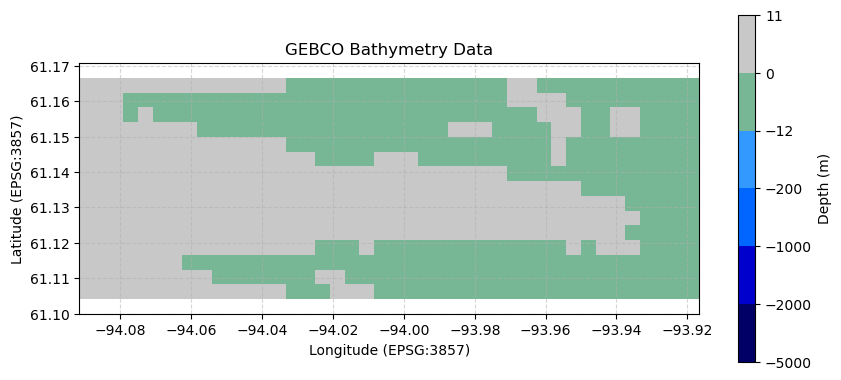

In [83]:
### GEBCO VISUALISATION

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Transformer

# Check if GEBCO data exists
if not gebco_data_exist:
    print("Skipping as gebco_data_exist is False.")
else:
    # File path
    tiff_path = "./input/bathymetry_gebco_2024_3857_clipped.tif"

    # Step 1: Open the Raster File
    with rasterio.open(tiff_path) as dataset:
        raster_data = dataset.read(1).astype(np.float32)

        # Get metadata
        nodata_value = dataset.nodata
        bounds = dataset.bounds

        print(f"NoData Value: {nodata_value}")

        # Mask NoData values
        if nodata_value is not None and np.isfinite(nodata_value):
            raster_data[raster_data == nodata_value] = np.nan

        # Check if the raster contains valid data
        valid_data = raster_data[~np.isnan(raster_data)]
        if valid_data.size == 0:
            print("Warning: No valid raster data available.")
            min_value, max_value = None, None
        else:
            min_value = np.nanmin(valid_data)
            max_value = np.nanmax(valid_data)

        # Compute resolution in degrees
        resolution_x_deg = (bounds.right - bounds.left) / dataset.width
        resolution_y_deg = (bounds.top - bounds.bottom) / dataset.height
        resolution_deg = (resolution_x_deg + resolution_y_deg) / 2  # Average resolution

        # Convert resolution to meters
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        res_x_m, _ = transformer.transform(resolution_x_deg, 0)
        _, res_y_m = transformer.transform(0, resolution_y_deg)
        resolution_m = (abs(res_x_m) + abs(res_y_m)) / 2

        # Count pixels below sea level
        below_zero_count = np.sum(raster_data < 0) if valid_data.size > 0 else 0

        print(f"Raster Min Value: {min_value}")
        print(f"Raster Max Value: {max_value}")
        print(f"Resolution: {resolution_deg:.6f} degrees")
        print(f"Resolution: {resolution_m:.2f} meters")
        print(f"Pixels Below Sea Level: {below_zero_count}")

        # Define depth categories and colors
        depth_bins = [min_value, -5000, -2000, -1000, -200, 0, max_value]  
        depth_bins = sorted(depth_bins)  # Ensure bins are strictly increasing

        colors = [
            (0, 0, 102),   # Deep ocean (-5000m)
            (0, 0, 204),   # Deep mid (-2000m)
            (0, 102, 255),  # Mid-depth (-1000m)
            (51, 153, 255),  # Shallow (-200m)
            (120, 183, 150),  # Land (0m)
            (200, 200, 200),  # Above land max (Newly added color)
        ]

        # Convert RGB colors to 0-1 range
        colors = [(r/255, g/255, b/255) for r, g, b in colors]

        # Create colormap
        cmap = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(depth_bins, cmap.N)  # Now bins are sorted

        # Step 2: Visualize Raster with Matplotlib
        fig, ax = plt.subplots(figsize=(10, 6))

        img = ax.imshow(raster_data, cmap=cmap, norm=norm, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
        cbar = plt.colorbar(img, ax=ax, ticks=depth_bins, shrink=0.75)
        cbar.set_label("Depth (m)")

        ax.set_title("GEBCO Bathymetry Data")
        ax.set_xlabel("Longitude (EPSG:3857)")
        ax.set_ylabel("Latitude (EPSG:3857)")
        ax.grid(True, linestyle="--", alpha=0.5)

        # Show the plot
        plt.show()


In [84]:
### REPROJECT GEBCO - NEW CODE
import rasterio
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point
from rasterio.transform import rowcol

# Step 1: Extract Centroids
def extract_gebco_centroids(input_tif, output_geojson):
    """Extracts centroid locations and values from GEBCO raster and saves as a GeoDataFrame."""
    print("Extracting centroids from GEBCO raster...")

    with rasterio.open(input_tif) as src:
        nodata_value = src.nodata
        data = src.read(1)

        valid_pixels = np.count_nonzero(data != nodata_value)
        print(f"GEBCO Original Valid Pixels: {valid_pixels}")

        rows, cols = np.where(data != nodata_value)
        values = data[rows, cols]
        centroids = [Point(src.transform * (col + 0.5, row + 0.5)) for row, col in zip(rows, cols)]

        gdf = gpd.GeoDataFrame(pd.DataFrame({"depth": values}), geometry=centroids, crs=src.crs)
        gdf.to_file(output_geojson, driver="GeoJSON")
        print(f"Centroid points saved to {output_geojson}")

    return gdf

# Step 2: Convert Centroids (Reproject CRS)
def convert_gebco_centroids(gdf, reference_tif, output_geojson):
    """Converts extracted GEBCO centroids to match the CRS of the reference raster."""
    if gdf is None or gdf.empty:
        print("Error: No centroids available for conversion.")
        return None

    # Get target CRS from the reference raster
    with rasterio.open(reference_tif) as ref:
        target_crs = ref.crs  # Extract CRS dynamically
        print(f"Target CRS (from Reference Raster): {target_crs}")

    print(f"GEBCO Centroids CRS (Before Conversion): {gdf.crs}")
    gdf = gdf.to_crs(target_crs)
    gdf["x"] = gdf.geometry.x
    gdf["y"] = gdf.geometry.y

    print(f"GEBCO Centroids CRS (After Conversion): {gdf.crs}")
    gdf.to_file(output_geojson, driver="GeoJSON")
    print(f"Converted centroid points saved to {output_geojson}")

    return gdf

# Step 3: Make Raster (Rasterize the Converted Centroids)
def rasterize_centroids(gdf, reference_tif, output_tif):
    """Rasterizes centroid points onto a new raster grid."""
    print("Rasterizing centroids onto the new grid...")

    if gdf is None or gdf.empty:
        print("Error: No centroids available for rasterization. Skipping process.")
        return

    with rasterio.open(reference_tif) as ref:
        ref_transform, ref_crs, ref_width, ref_height = ref.transform, ref.crs, ref.width, ref.height
        ref_bounds = ref.bounds
        nodata_value = ref.nodata ### NEW CODE

        print(f"Reference Raster CRS: {ref_crs}")
        print(f"Reference Raster Bounding Box: {ref_bounds}")

        gdf = gdf.cx[ref_bounds.left:ref_bounds.right, ref_bounds.bottom:ref_bounds.top]
        if gdf.empty:
            print("Error: No centroids fall within raster extent.")
            return

        print(f"Centroids within raster extent: {len(gdf)}")

        raster_data = np.full((ref_height, ref_width), nodata_value, dtype="float32")
        valid_points = 0

        for _, row in gdf.iterrows():
            x, y, value = row.geometry.x, row.geometry.y, row.depth
            try:
                row_idx, col_idx = rowcol(ref_transform, x, y)
                if 0 <= row_idx < ref_height and 0 <= col_idx < ref_width:
                    # Exclude values >= 0
                    if value < 0:
                        raster_data[row_idx, col_idx] = value
                        valid_points += 1
            except Exception as e:
                print(f"Error mapping point ({x}, {y}): {e}")

        if valid_points == 0:
            print("Error: No valid centroid points mapped to raster grid.")
            gebco_data_exist = False
            return

        print(f"Successfully mapped {valid_points} centroids to raster grid.")

        meta = ref.meta.copy()
        meta.update({
            "driver": "GTiff",
            "width": ref_width,
            "height": ref_height,
            "crs": ref_crs,
            "transform": ref_transform,
            "nodata": nodata_value,
            "dtype": "float32"
        })

        with rasterio.open(output_tif, "w", **meta) as dst:
            dst.write(raster_data, 1)

        reprojected_valid_pixels = np.count_nonzero(raster_data != nodata_value)
        print(f"GEBCO Reprojected Valid Pixels: {reprojected_valid_pixels}")

def compute_statistics(raster_path):
    """Computes statistics (min, max, mean, std) for each band in the raster."""
    with rasterio.open(raster_path) as src:
        stats = {}
        nodata_value = src.nodata
        for band in range(1, src.count + 1):
            data = src.read(band)

            # Exclude NoData values
            valid_data = data[data != nodata_value] if nodata_value is not None else data
            valid_data = valid_data[np.isfinite(valid_data)]  # Remove NaN/Inf

            if valid_data.size > 0:
                stats[band] = {
                    "min": np.min(valid_data),
                    "max": np.max(valid_data),
                    "mean": np.mean(valid_data),
                    "std": np.std(valid_data)
                }
            else:
                stats[band] = {"min": None, "max": None, "mean": None, "std": None}

        return stats

# **Execution Workflow**
input_tif1 = "./input/bathymetry_gebco_2024_3857_clipped.tif"
centroids_geojson = "./output/Bathymetric_Features/gebco_centroids.geojson"
converted_geojson = "./output/Bathymetric_Features/gebco_centroids_converted.geojson"
input_tif2 = "./output/Bathymetric_Features/reprojected_bathymetry.tif"
output_raster = "./output/Bathymetric_Features/reprojected_3857_gebco_to_match.tif"

gdf = extract_gebco_centroids(input_tif1, centroids_geojson)
gdf_converted = convert_gebco_centroids(gdf, input_tif2, converted_geojson)
rasterize_centroids(gdf_converted, input_tif2, output_raster)

# Step 4: Compute statistics on the merged raster
print("\n== Merged Raster Statistics ==")
merged_stats = compute_statistics(output_raster)
for band, stats in merged_stats.items():
    print(f"Band {band} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")

print(f"NoData value: {rasterio.open(output_raster).nodata}")
print(f"CRS: {rasterio.open(output_raster).crs}")



Extracting centroids from GEBCO raster...
GEBCO Original Valid Pixels: 630
Centroid points saved to ./output/Bathymetric_Features/gebco_centroids.geojson
Target CRS (from Reference Raster): EPSG:32615
GEBCO Centroids CRS (Before Conversion): GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
GEBCO Centroids CRS (After Conversion): PROJCS["WGS 84 / UTM zone 15N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",

./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif
=== DEBUG: RASTER METADATA CHECK ===
  [Merged Raster] shape: (725, 942), transform: | 10.00, 0.00, 441195.00|
| 0.00,-10.00, 6781935.00|
| 0.00, 0.00, 1.00|, nodata: 3.4028234663852886e+38
  [GEBCO Raster ] shape: (725, 942),  transform: | 10.00, 0.00, 441195.00|
| 0.00,-10.00, 6781935.00|
| 0.00, 0.00, 1.00|,  nodata: 3.4028234663852886e+38
nodata_value (from merged): 3.4028234663852886e+38

=== GEBCO-BUFFER DEBUG (Aggregated) ===
   Total potential GEBCO fill: 294
     Of which inside buffer:  228
     Of which outside buffer: 66
Merged raster with GEBCO saved as: ./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif
Final Statistics:
   🟥 USER pixels: 73069
   🟩 NONNA 10 pixels: 263746
   🟦 NONNA 100 pixels: 125562
   🟨 GEBCO (or leftover) pixels: 220573

=== DEBUG: ACCUMULATED MERGE INFO ===
   Total NoData in Band 1 (before fill): 637264
   Total GEBCO (non-NaN) in window read: 317
   Total covered by use

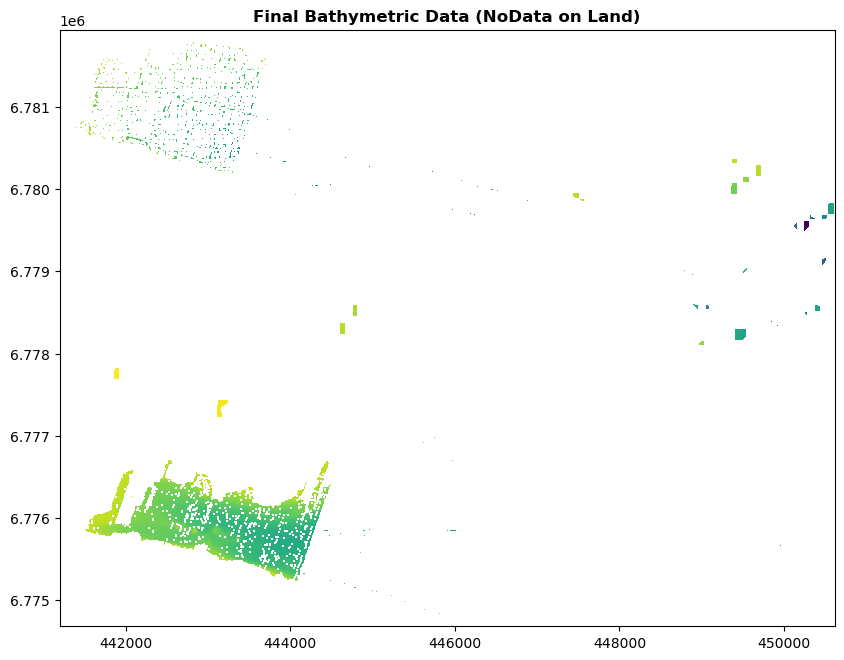

In [86]:
### MERGE USER BATHYMETRY + NONNA 10 + NONNA 100 + GEBCO WITH BUFFER

import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
from rasterio.plot import show
from scipy.ndimage import binary_dilation

# Define input files
if gebco_data_exist:
    reprojected_gebco = "./output/Bathymetric_Features/reprojected_3857_gebco_to_match.tif"  # GEBCO Raster
if nonna10_data_exist and nonna100_data_exist:
    input_tif2 = "./output/Bathymetric_Features/merged_bathymetry_10_100.tif"  # High-resolution bathymetry
elif nonna10_data_exist:
    input_tif2 = "./output/Bathymetric_Features/merged_bathymetry_10.tif"  # High-resolution bathymetry  
elif nonna100_data_exist:
    input_tif2 = "./output/Bathymetric_Features/merged_bathymetry_100.tif"  # High-resolution bathymetry 
else:
    input_tif2 = "./output/Bathymetric_Features/reprojected_bathymetry.tif"  # High-resolution bathymetry 
land_area_geojson = "./output/Land_Features/Land_Area.geojson"  # Land polygons

# Define output files
output_merged_tif = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif"

# NoData value to use consistently
#COMMON_NODATA_VALUE = -9999

def create_buffer_mask(raster_tif, buffer_pixels=50):
    """Creates a buffer mask around valid bathymetry data."""
    with rasterio.open(raster_tif) as src:
        nodata_value = src.nodata
        valid_data = src.read(1)

        # Create binary mask: 1 where user data is valid, 0 otherwise
        data_mask = valid_data != nodata_value

        # Apply dilation to create the buffer zone
        buffer_mask = binary_dilation(data_mask, iterations=buffer_pixels)

        return buffer_mask

def merge_gebco_raster_with_buffer(input_tif2, reprojected_gebco, output_tif, buffer_pixels=50, nonna100_data_exist=False):
    """
    Merges GEBCO onto an already merged USER + NONNA 10 + NONNA 100 raster.
    Ensures GEBCO does not overwrite the buffered region and retains existing pixel markings.
    Preserves:
      - USER = 1
      - NONNA 10 = 2
      - NONNA 100 = 3
      - New buffer = 3 (if NONNA 100 exists)
      - GEBCO = 4 (wherever leftover or NoData)
    """
    with rasterio.open(input_tif2) as src_merged, rasterio.open(reprojected_gebco) as src_gebco:
        # Print shape, transform, and nodata for debugging
        print("=== DEBUG: RASTER METADATA CHECK ===")
        print(f"  [Merged Raster] shape: {src_merged.shape}, transform: {src_merged.transform}, nodata: {src_merged.nodata}")
        print(f"  [GEBCO Raster ] shape: {src_gebco.shape},  transform: {src_gebco.transform},  nodata: {src_gebco.nodata}")

        # nodata_value = src_merged.nodata if src_merged.nodata is not None else -9999
        nodata_value = src_merged.nodata
        print(f"nodata_value (from merged): {nodata_value}")

        meta = src_merged.meta.copy()
        meta.update({"count": 2, "nodata": nodata_value, "dtype": "float32"})

        # Generate the buffer mask
        buffer_mask = create_buffer_mask(input_tif2, buffer_pixels)

        # Initialize pixel counts
        user_count = nonna10_count = nonna100_count = gebco_count = 0

        # These are for debugging accumulators
        total_no_data_pixels = 0
        total_gebco_data_mask_pixels = 0
        total_gebco_valid_pixels = 0
        total_covered_by_user_nonna = 0

        # Create accumulators BEFORE the for-loop:
        total_potential_gebco_fill = 0
        total_in_buffer = 0

        with rasterio.open(output_tif, "w", **meta) as dst:
            for idx, window in src_merged.block_windows(1):
                # Read the block from Band 1
                merged_data = src_merged.read(1, window=window)
                # Read the block from GEBCO
                gebco_data = src_gebco.read(1, window=window)

                # Try to read source band (Band 2), if missing initialize it
                try:
                    source_band = src_merged.read(2, window=window)
                except IndexError:
                    source_band = np.full_like(merged_data, nodata_value, dtype=np.float32)

                # Valid pixel masks in Band 2
                user_valid = (source_band == 1)
                nonna10_valid = (source_band == 2)
                nonna100_valid = (source_band == 3)

                # 1) Where Band 1 is nodata
                no_data_mask = (merged_data == nodata_value)

                # 2) Where GEBCO data is not nodata
                #    NOTE: If GEBCO nodata != merged nodata, this might fail. Double-check.
                gebco_data_mask = (gebco_data != nodata_value)

                # 3) Combine them
                gebco_valid = no_data_mask & gebco_data_mask & ~(user_valid | nonna10_valid | nonna100_valid)

                # Prepare local buffer window mask
                buffer_window = buffer_mask[
                    window.row_off : window.row_off + window.height,
                    window.col_off : window.col_off + window.width
                ]
                
                # potential GEBCO fill: NoData in band1 + valid data in GEBCO
                potential_gebco_mask = no_data_mask & gebco_data_mask
                in_buffer_mask = potential_gebco_mask & buffer_window
                
                potential_gebco_count = np.sum(potential_gebco_mask)
                in_buffer_count = np.sum(in_buffer_mask)
                
                total_potential_gebco_fill += potential_gebco_count
                total_in_buffer += in_buffer_count

                # Do not overwrite inside the buffer
                #gebco_valid[buffer_window] = False

                # ---------- DEBUG: Print local window info ----------
                local_no_data = np.sum(no_data_mask)
                local_gebco_data = np.sum(gebco_data_mask)
                local_user_nonna = np.sum(user_valid | nonna10_valid | nonna100_valid)
                local_gebco_valid = np.sum(gebco_valid)

                # Accumulate for entire raster
                total_no_data_pixels += local_no_data
                total_gebco_data_mask_pixels += local_gebco_data
                total_covered_by_user_nonna += local_user_nonna
                total_gebco_valid_pixels += local_gebco_valid

                # Uncomment for more granular debug in each window:
                #print(f"[Window {idx}] no_data_mask={local_no_data}, gebco_data_mask={local_gebco_data}, userOrNonna={local_user_nonna}, => gebco_valid={local_gebco_valid}")

                # -------------------------------
                # Band 1 Merge: fill from GEBCO if no data in original
                # -------------------------------
                final_data = np.where(
                    (user_valid | nonna10_valid | nonna100_valid),
                    merged_data,
                    np.where(gebco_valid, gebco_data, nodata_value)
                )

                # -------------------------------
                # Band 2: label the buffer (and the original NONNA100) as 3
                # everything else that isn't user or NONNA is 4
                # -------------------------------
                if nonna100_data_exist:
                    final_source_band = np.where(
                        user_valid, 1,
                        np.where(
                            nonna10_valid, 2,
                            np.where(nonna100_valid | buffer_window, 3, 4)
                        )
                    )
                else:
                    final_source_band = np.where(
                        user_valid, 1,
                        np.where(nonna10_valid, 2, 4)
                    )

                # Update pixel counts
                user_count += np.sum(final_source_band == 1)
                nonna10_count += np.sum(final_source_band == 2)
                nonna100_count += np.sum(final_source_band == 3)
                gebco_count += np.sum(final_source_band == 4)

                # Write updated data
                dst.write(final_data, indexes=1, window=window)
                dst.write(final_source_band, indexes=2, window=window)

        # End of the windows loop
        print(f"\n=== GEBCO-BUFFER DEBUG (Aggregated) ===")
        print(f"   Total potential GEBCO fill: {total_potential_gebco_fill}")
        print(f"     Of which inside buffer:  {total_in_buffer}")
        print(f"     Of which outside buffer: {total_potential_gebco_fill - total_in_buffer}")

        print(f"Merged raster with GEBCO saved as: {output_tif}")
        print(f"Final Statistics:")
        print(f"   🟥 USER pixels: {user_count}")
        print(f"   🟩 NONNA 10 pixels: {nonna10_count}")
        print(f"   🟦 NONNA 100 pixels: {nonna100_count}")
        print(f"   🟨 GEBCO (or leftover) pixels: {gebco_count}")

        # ---------- DEBUG: Print aggregated stats ----------
        print("\n=== DEBUG: ACCUMULATED MERGE INFO ===")
        print(f"   Total NoData in Band 1 (before fill): {total_no_data_pixels}")
        print(f"   Total GEBCO (non-NaN) in window read: {total_gebco_data_mask_pixels}")
        print(f"   Total covered by user or NONNA:       {total_covered_by_user_nonna}")
        print(f"   Total pass the 'gebco_valid' check:   {total_gebco_valid_pixels}")

def mask_land_areas(input_raster, land_vector):
    """
    Masks land areas by setting raster values to NoData where they overlap with land polygons.
    Ensures both Band 1 (depth) and Band 2 (source tracking) are masked correctly.
    """
    # Load land polygons
    land_gdf = gpd.read_file(land_vector)
    
    # Convert to raster's CRS
    with rasterio.open(input_raster, "r+") as src:
        land_gdf = land_gdf.to_crs(src.crs)  # Ensure same CRS
        land_shapes = land_gdf.geometry  # Get land polygons
        nodata_value = src.nodata

        # Create a land mask (True for land, False for water)
        land_mask = geometry_mask(land_shapes, transform=src.transform, invert=True,
                                  out_shape=(src.height, src.width))

        # Read both bands (depth & source tracking)
        data_band1 = src.read(1)  # Depth values
        data_band2 = src.read(2)  # Source tracking

        print(f"NoData value: {nodata_value}")

        # Apply the land mask (set land pixels to NoData)
        data_band1[land_mask] = nodata_value
        data_band2[land_mask] = nodata_value  # Now masks source tracking as well

        # Save the updated raster
        src.write(data_band1, 1)
        src.write(data_band2, 2)  # Ensure Band 2 is correctly updated
        src.nodata = nodata_value  # Ensure metadata reflects NoData value

    print(f"Land-masked raster (Band 1 & Band 2) saved at: {input_raster}")

    def compute_statistics(raster_path):
        """Computes statistics (min, max, mean, std) for each band in the raster."""
        with rasterio.open(raster_path) as src:
            stats = {}
            nodata_value = src.nodata
            for band in range(1, src.count + 1):
                data = src.read(band)

                # Exclude NoData values
                valid_data = data[data != nodata_value] if nodata_value is not None else data
                valid_data = valid_data[np.isfinite(valid_data)]  # Remove NaN/Inf

                if valid_data.size > 0:
                    stats[band] = {
                        "min": np.min(valid_data),
                        "max": np.max(valid_data),
                        "mean": np.mean(valid_data),
                        "std": np.std(valid_data)
                    }
                else:
                    stats[band] = {"min": None, "max": None, "mean": None, "std": None}

            return stats

# **Execution Steps**

print(output_merged_tif)
# Step 1: Merge GEBCO Data Only Where No Data Exists in the Bathymetric Dataset
if gebco_data_exist:
    merge_gebco_raster_with_buffer(input_tif2, reprojected_gebco, output_merged_tif, 50, nonna100_data_exist)
else:
    merge_gebco_raster_with_buffer(input_tif2, input_tif2, output_merged_tif, 50, nonna100_data_exist)

# Step 2: Apply Land Mask
mask_land_areas(output_merged_tif, land_area_geojson)


# Step 4: Compute statistics on the merged raster
print(f"\n== Merged Raster Statistics =={input_tif2}")
merged_stats = compute_statistics(input_tif2)
for band, stats in merged_stats.items():
    print(f"Band {band} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")
print(f"NoData value: {rasterio.open(input_tif2).nodata}")
print(f"CRS: {rasterio.open(input_tif2).crs}")

# Step 4: Compute statistics on the merged raster
print(f"\n== Merged Raster Statistics =={reprojected_gebco}")
merged_stats = compute_statistics(reprojected_gebco)
for band, stats in merged_stats.items():
    print(f"Band {band} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")
print(f"NoData value: {rasterio.open(reprojected_gebco).nodata}")
print(f"CRS: {rasterio.open(reprojected_gebco).crs}")

# Step 4: Compute statistics on the merged raster
print(f"\n== Merged Raster Statistics =={output_merged_tif}")
merged_stats = compute_statistics(output_merged_tif)
for band, stats in merged_stats.items():
    print(f"Band {band} - Min: {stats['min']}, Max: {stats['max']}, Mean: {stats['mean']}, Std: {stats['std']}")
print(f"NoData value: {rasterio.open(output_merged_tif).nodata}")
print(f"CRS: {rasterio.open(output_merged_tif).crs}")

# Step 3: Display the Final Raster with Land Masked
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(output_merged_tif) as final_src:
    show(final_src, ax=ax, title="Final Bathymetric Data (NoData on Land)")
plt.show()


Reprojected GEBCO raster saved as: ./output/Bathymetric_Features/reprojected_merged_bathymetry_10_100_gebco_4326.tif
Clipped GEBCO raster saved as: ./output/Bathymetric_Features/clipped_gebco.tif
Clipped Raster Min Value: -18.799999237060547
Clipped Raster Max Value: 3.799999952316284
Resolution: 0.000158 degrees
Resolution: 13.06 meters
Pixels Below Sea Level: 25580



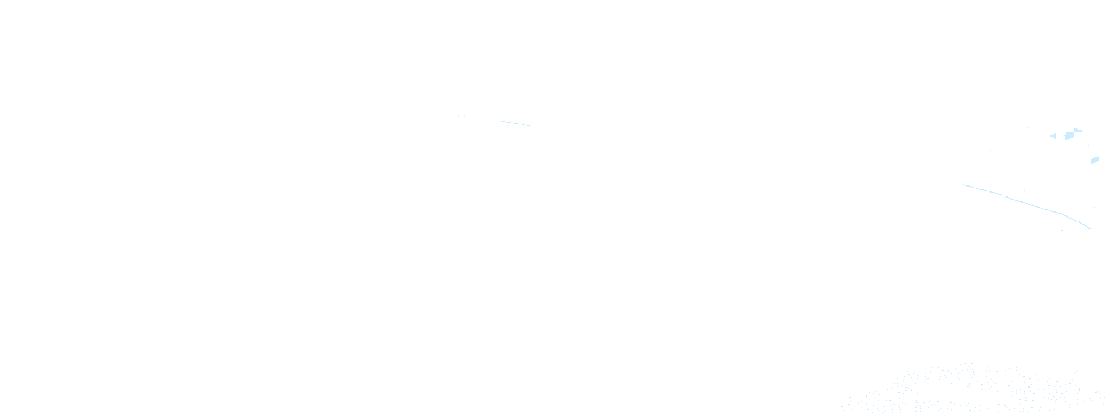
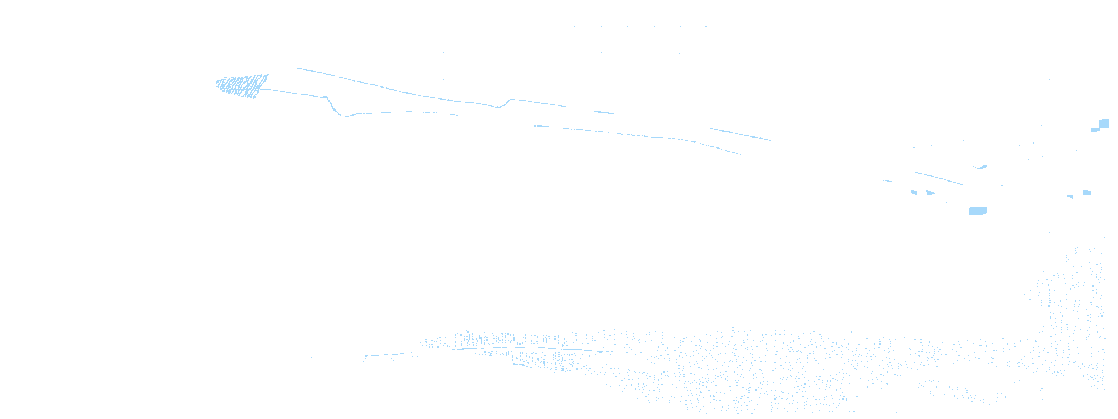
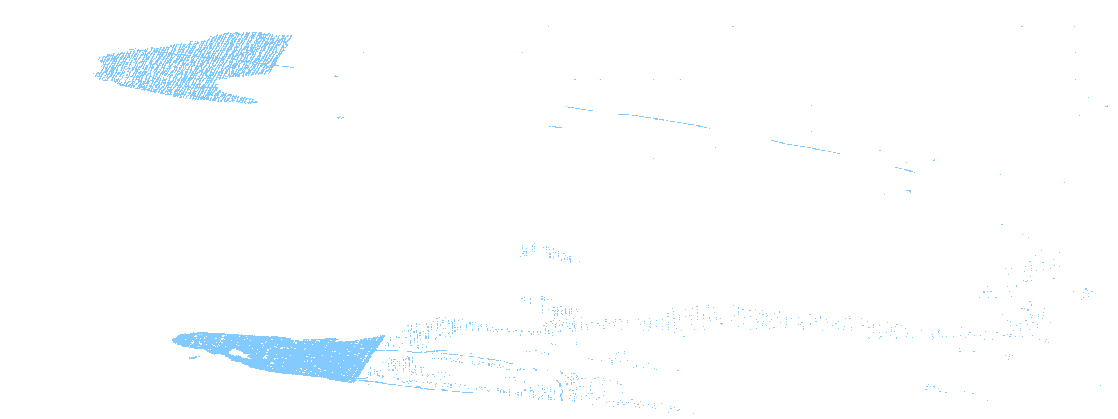
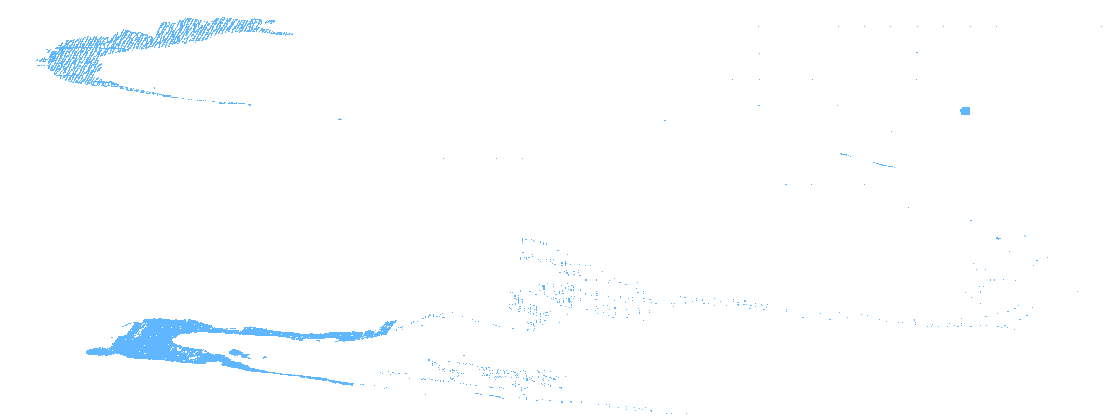
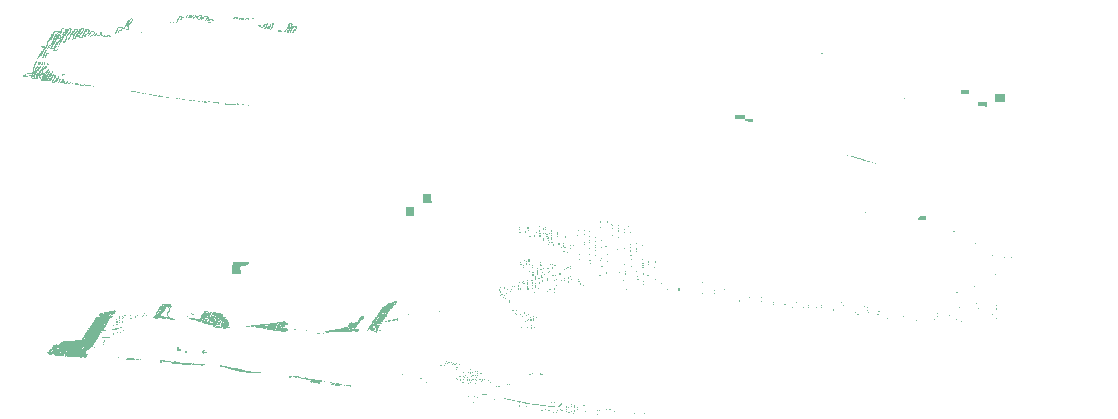

In [87]:
### VISUALISATION BAND 1 IN LAYERS

import folium
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling
from folium.raster_layers import ImageOverlay

# Define file paths
input_tiff = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif"  # GEBCO raster (EPSG:4326)
reprojected_tiff = "./output/Bathymetric_Features/reprojected_merged_bathymetry_10_100_gebco_4326.tif"  # Output reprojected raster
clip_geojson = "./output/Chart_Features/chartlimit_utm.geojson"  # Clipping boundary
clipped_tiff = "./output/Bathymetric_Features/clipped_gebco.tif"  # Output clipped raster

# Step 1: Reproject the Raster to EPSG:4326
with rasterio.open(input_tiff) as src:
    dst_crs = "EPSG:4326"
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    new_meta = src.meta.copy()
    new_meta.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })
    
    with rasterio.open(reprojected_tiff, "w", **new_meta) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

print(f"Reprojected GEBCO raster saved as: {reprojected_tiff}")

# Step 1: Load Clipping Boundary (chartlimit_utm.geojson)
clip_boundary = gpd.read_file(clip_geojson)

# Ensure the clipping boundary has the same CRS as GEBCO
with rasterio.open(reprojected_tiff) as dataset:
    raster_crs = dataset.crs
    if clip_boundary.crs != raster_crs:
        clip_boundary = clip_boundary.to_crs(raster_crs)

# Step 2: Clip the GEBCO Raster Using Boundary
with rasterio.open(reprojected_tiff) as dataset:
    clip_geometry = [geom.__geo_interface__ for geom in clip_boundary.geometry]

    # Clip raster
    clipped_data, clipped_transform = mask(dataset, clip_geometry, crop=True, nodata=dataset.nodata)

    # Copy metadata and update for the clipped raster
    clipped_meta = dataset.meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_data.shape[1],
        "width": clipped_data.shape[2],
        "transform": clipped_transform
    })

    # Save clipped raster
    with rasterio.open(clipped_tiff, "w", **clipped_meta) as dest:
        dest.write(clipped_data)

print(f"Clipped GEBCO raster saved as: {clipped_tiff}")

# Step 3: Load Clipped Raster for Visualization
with rasterio.open(clipped_tiff) as dataset:
    raster_data = dataset.read(1)  # Read first band
    nodata_value = dataset.nodata

    # Mask NoData values
    raster_data = np.where(raster_data == nodata_value, np.nan, raster_data)

    # Compute min/max depth values
    valid_data = raster_data[~np.isnan(raster_data)]
    min_value = np.nanmin(valid_data)
    max_value = np.nanmax(valid_data)

    # Calculate resolution
    resolution_x_deg = (dataset.bounds.right - dataset.bounds.left) / dataset.width
    resolution_y_deg = (dataset.bounds.top - dataset.bounds.bottom) / dataset.height
    resolution_deg = (resolution_x_deg + resolution_y_deg) / 2

    # Estimate resolution in meters (approximate conversion)
    mid_latitude = (dataset.bounds.top + dataset.bounds.bottom) / 2
    resolution_x_m = resolution_x_deg * 111320 * np.cos(np.radians(mid_latitude))
    resolution_y_m = resolution_y_deg * 111320
    resolution_m = (resolution_x_m + resolution_y_m) / 2

    # Count pixels below sea level
    below_zero_count = np.sum(raster_data < 0)

    print(f"Clipped Raster Min Value: {min_value}")
    print(f"Clipped Raster Max Value: {max_value}")
    print(f"Resolution: {resolution_deg:.6f} degrees")
    print(f"Resolution: {resolution_m:.2f} meters")
    print(f"Pixels Below Sea Level: {below_zero_count}")

    # Step 4: Define Depth Categories & Colors
    depth_bins = [np.nanmin(raster_data), -10, -5, -2, 0, np.nanmax(raster_data)]
    colors = [
        "rgb(201, 237, 255)",  # DEPDW (-30 to -10)
        "rgb(167, 217, 251)",  # DEPMD (-10 to -5)
        "rgb(130, 202, 255)",  # DEPMS (-5 to -2)
        "rgb(97, 183, 255)",   # DEPVS (-2 to 0)
        "rgb(120, 183, 150)",  # GREEN (Land)
    ]

    # Generate depth masks
    masks = [(raster_data >= lower) & (raster_data < upper) for lower, upper in zip(depth_bins[:-1], depth_bins[1:])]

# Step 5: Create Folium Map
map_center = [(dataset.bounds.bottom + dataset.bounds.top) / 2, 
              (dataset.bounds.left + dataset.bounds.right) / 2]
m = folium.Map(location=map_center, zoom_start=11)

# Step 6: Add Depth Layers with Toggle Option
for i, (mask, color) in enumerate(zip(masks, colors)):
    layer_image = np.zeros((*raster_data.shape, 4), dtype=np.uint8)  # Include alpha channel for transparency
    rgb = tuple(int(c) for c in color.replace("rgb(", "").replace(")", "").split(","))
    layer_image[mask] = (*rgb, 255)  # RGB + Alpha (fully opaque)
    layer_image[~mask] = (0, 0, 0, 0)  # Transparent

    ImageOverlay(
        image=layer_image,
        bounds=[[dataset.bounds.bottom, dataset.bounds.left], [dataset.bounds.top, dataset.bounds.right]],
        opacity=0.8,
        interactive=True,
        name=f"Depth {depth_bins[i]} to {depth_bins[i+1]} m",
        zindex=1,
    ).add_to(m)

# Step 7: Add Layer Control for Toggle
folium.LayerControl(collapsed=False).add_to(m)

# Step 8: Add Legend
legend_html = f"""
<div style="
    position: fixed;
    bottom: 10px;
    left: 10px;
    width: 200px;
    height: 280px;
    background-color: white;
    z-index:9999;
    font-size:14px;
    border:2px solid grey;
    padding:10px;
    text-align: center;">
    <b>GEBCO Stats</b><br>
    Min: {min_value:.2f} m<br>
    Max: {max_value:.2f} m<br>
    Resolution: {resolution_deg:.6f}°<br>
    Resolution: {resolution_m:.2f} meters<br>
    Pixels Below Zero: {below_zero_count}<br><br>
    <b>Depth Scale (m)</b><br>
    <div style='background-color: rgb(201, 237, 255); width: 100px; height: 15px; display: inline-block;'></div> < -10 m <br>
    <div style='background-color: rgb(167, 217, 251); width: 100px; height: 15px; display: inline-block;'></div> -10 to -5 m <br>
    <div style='background-color: rgb(130, 202, 255); width: 100px; height: 15px; display: inline-block;'></div> -5 to -2 m <br>
    <div style='background-color: rgb(97, 183, 255); width: 100px; height: 15px; display: inline-block;'></div> -2 to 0 m <br>
    <div style='background-color: rgb(120, 183, 150); width: 100px; height: 15px; display: inline-block;'></div> 0 (Land) <br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Step 9: Save and Display the Map
#m.save("clipped_gebco_folium.html")
m


In [91]:
### BAND 2 STATISTICS

import rasterio
import numpy as np

# Define input file
input_tiff_10 = "./output/Bathymetric_Features/merged_bathymetry_10.tif"  # Original raster before processing
input_tiff_100 = "./output/Bathymetric_Features/merged_bathymetry_10_100.tif"  # Original raster before processing
input_tiff_gebco = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif"  # Original raster before processing

def count_band2_values(raster_path):
    """Counts unique values in Band 2 (source tracking) before any processing."""
    with rasterio.open(raster_path) as src:
        if src.count < 2:
            print(f"Error: {raster_path} does not have a second band for source tracking.")
            return

        band_2 = src.read(2)  # Read Band 2 (source tracking)
        nodata_value = src.nodata if src.nodata is not None else -9999

        # Count the number of pixels in each category (excluding NoData)
        unique_values, counts = np.unique(band_2[band_2 != nodata_value], return_counts=True)
        total_pixels = band_2.size

        print("\n**Band 2 Source Tracking Counts Before Processing** 📊")
        print(f"Total Pixels: {total_pixels}")

        # Define source labels for better readability
        source_labels = {
            1: "USER Data",
            2: "NONNA 10",
            3: "NONNA 100",
            4: "GEBCO"
        }

        for value, count in zip(unique_values, counts):
            label = source_labels.get(value, f"Unknown ({value})")
            percentage = (count / total_pixels) * 100
            print(f"  {label}: {count} pixels ({percentage:.2f}%)")

        # Count NoData pixels separately
        nodata_count = np.sum(band_2 == nodata_value)
        nodata_percentage = (nodata_count / total_pixels) * 100
        print(f"NoData Pixels: {nodata_count} pixels ({nodata_percentage:.2f}%)\n")

# Run Band 2 count function before any processing
count_band2_values(input_tiff_10)
count_band2_values(input_tiff_100)
count_band2_values(input_tiff_gebco)



**Band 2 Source Tracking Counts Before Processing** 📊
Total Pixels: 682950
  USER Data: 73069 pixels (10.70%)
  NONNA 10: 7238 pixels (1.06%)
  NoData Pixels: 602643 pixels (88.24%)


**Band 2 Source Tracking Counts Before Processing** 📊
Total Pixels: 682950
  USER Data: 73069 pixels (10.70%)
  NONNA 10: 263746 pixels (38.62%)
  NONNA 100: 1838 pixels (0.27%)
  NoData Pixels: 344297 pixels (50.41%)


**Band 2 Source Tracking Counts Before Processing** 📊
Total Pixels: 682950
  USER Data: 71606 pixels (10.48%)
  NONNA 10: 250382 pixels (36.66%)
  NONNA 100: 102104 pixels (14.95%)
  GEBCO: 141200 pixels (20.68%)
  NoData Pixels: 117658 pixels (17.23%)



Reprojected raster (Band 2 only, NoData preserved) saved as: ./output/Bathymetric_Features/reprojected_merged_bathymetry_10_100_gebco_4326.tif
Clipped raster (Band 2 only, NoData preserved) saved as: ./output/Bathymetric_Features/clipped_gebco.tif



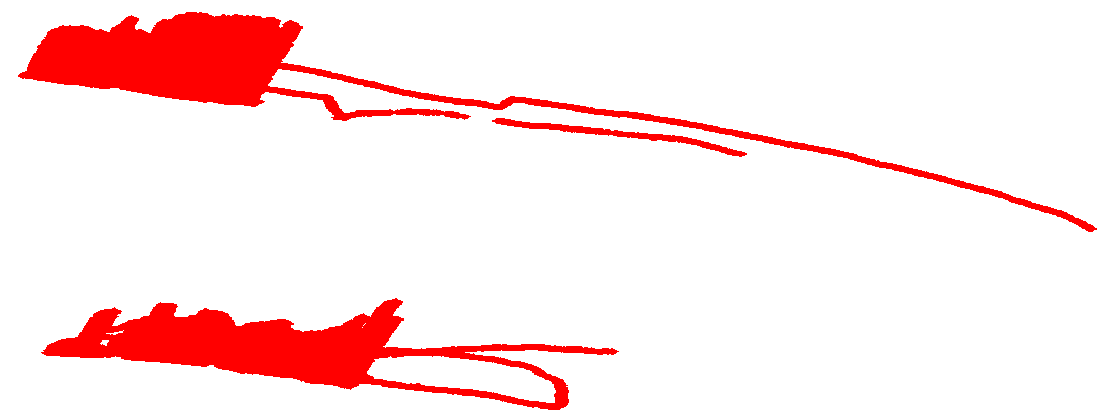
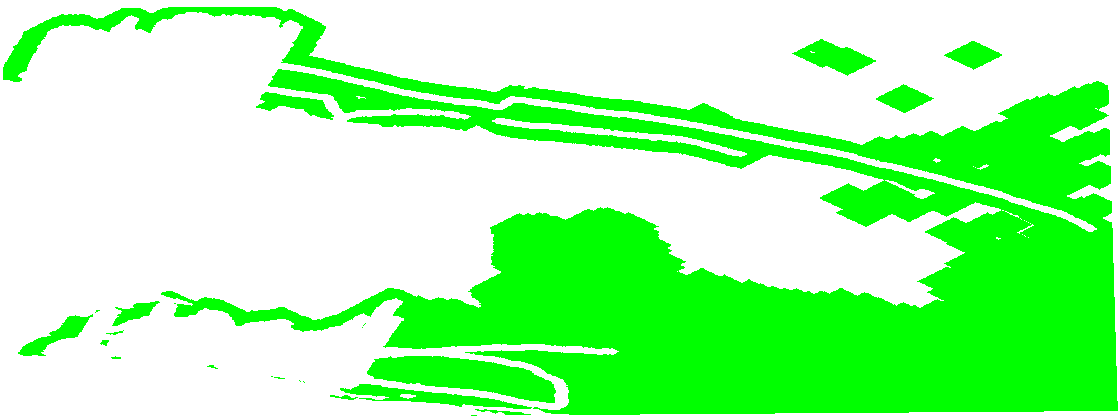
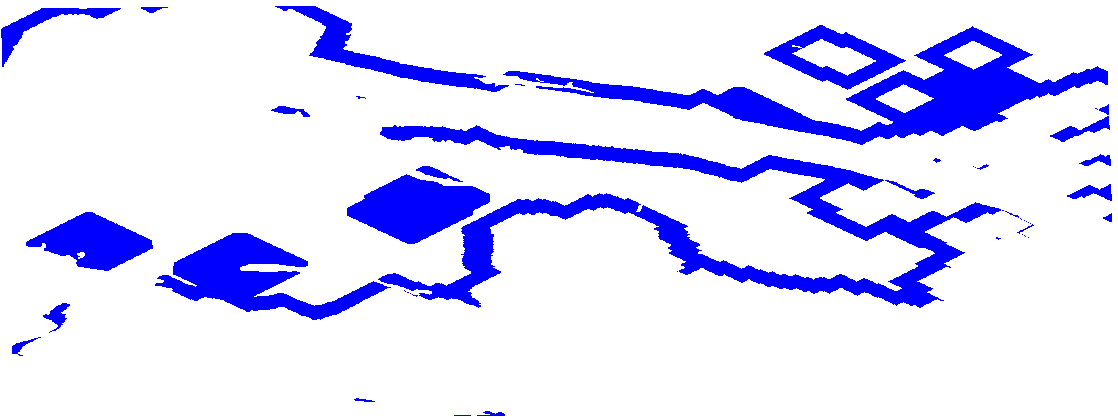
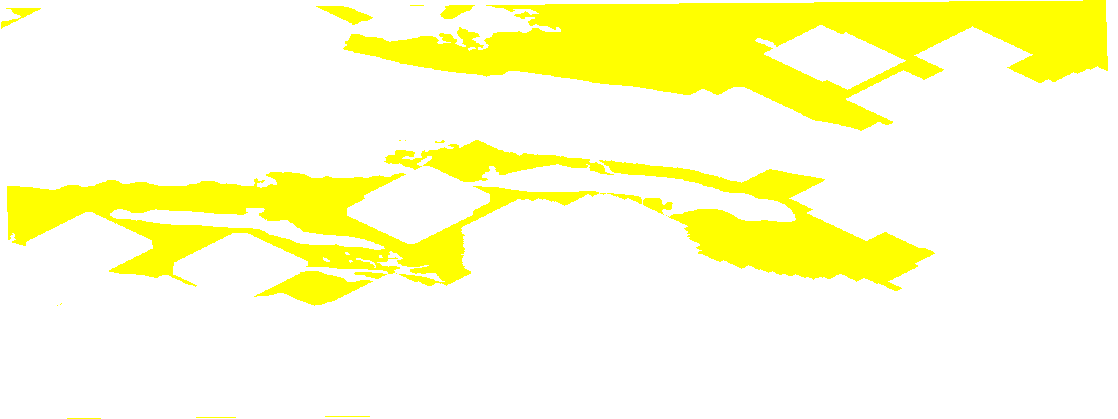

In [94]:
### VISUALISATION BAND 2 IN LAYERS

import folium
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling
from folium.raster_layers import ImageOverlay
from rasterio.warp import calculate_default_transform, reproject

# Define file paths
input_tiff = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif"  # Input raster
reprojected_tiff = "./output/Bathymetric_Features/reprojected_merged_bathymetry_10_100_gebco_4326.tif"  # Reprojected
clip_geojson = "./output/Chart_Features/chartlimit_utm.geojson"  # Clipping boundary
clipped_tiff = "./output/Bathymetric_Features/clipped_gebco.tif"  # Clipped output

# Step 1: Reproject the Raster to EPSG:4326 (Preserve NoData)
def reproject_raster(input_tif, output_tif, dst_crs="EPSG:4326"):
    with rasterio.open(input_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        nodata_value = src.nodata
        
        new_meta = src.meta.copy()
        new_meta.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "nodata": nodata_value
        })

        with rasterio.open(output_tif, "w", **new_meta) as dst:
            band2_reprojected = np.full((height, width), nodata_value, dtype=np.float32)  # Initialize with NoData

            reproject(
                source=rasterio.band(src, 2),
                destination=band2_reprojected,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
                dst_nodata=nodata_value  # Ensure NoData remains consistent
            )

            dst.write(band2_reprojected, 1)  # Store Band 2 correctly

    print(f"Reprojected raster (Band 2 only, NoData preserved) saved as: {output_tif}")

# Step 2: Clip the Raster Using Boundary (Preserve NoData)
def clip_raster(input_tif, clip_geojson, output_tif):
    clip_boundary = gpd.read_file(clip_geojson)

    with rasterio.open(input_tif) as dataset:
        raster_crs = dataset.crs
        if clip_boundary.crs != raster_crs:
            clip_boundary = clip_boundary.to_crs(raster_crs)

    with rasterio.open(input_tif) as dataset:
        clip_geometry = [geom.__geo_interface__ for geom in clip_boundary.geometry]

        # Clip raster while preserving NoData
        clipped_data, clipped_transform = mask(dataset, clip_geometry, crop=True, nodata=nodata_value)

        # Ensure NoData is correctly stored
        clipped_data[clipped_data == dataset.nodata] = COMMON_NODATA_VALUE  

        clipped_meta = dataset.meta.copy()
        clipped_meta.update({
            "driver": "GTiff",
            "height": clipped_data.shape[1],
            "width": clipped_data.shape[2],
            "transform": clipped_transform,
            "nodata": COMMON_NODATA_VALUE
        })

        with rasterio.open(output_tif, "w", **clipped_meta) as dest:
            dest.write(clipped_data)

    print(f"Clipped raster (Band 2 only, NoData preserved) saved as: {output_tif}")

# Step 3: Execute Reprojection & Clipping
reproject_raster(input_tiff, reprojected_tiff)
clip_raster(reprojected_tiff, clip_geojson, clipped_tiff)

# Step 4: Load Clipped Raster for Visualization
with rasterio.open(clipped_tiff) as dataset:
    raster_band2 = dataset.read(1)  # Source tracking only (Band 2)
    nodata_value = dataset.nodata

    # Mask NoData values
    raster_band2 = np.where(raster_band2 == nodata_value, np.nan, raster_band2)

    # Define color mapping for sources in Band 2
    source_colors = {
        1: "rgb(255, 0, 0)",    # USER - Red
        2: "rgb(0, 255, 0)",    # NONNA 10 - Green
        3: "rgb(0, 0, 255)",    # NONNA 100 - Blue
        4: "rgb(255, 255, 0)"   # GEBCO - Yellow
    }
    source_labels = {
        1: "USER Data",
        2: "NONNA 10",
        3: "NONNA 100",
        4: "GEBCO"
    }

    # Generate masks for source tracking
    source_masks = {key: (raster_band2 == key) for key in source_colors.keys()}

# Step 5: Create Folium Map
map_center = [(dataset.bounds.bottom + dataset.bounds.top) / 2, 
              (dataset.bounds.left + dataset.bounds.right) / 2]
m = folium.Map(location=map_center, zoom_start=11)

# Step 6: Add Source Band Layers with Names in Layer Control
for source_value, mask in source_masks.items():
    layer_image = np.zeros((*raster_band2.shape, 4), dtype=np.uint8)
    rgb = tuple(int(c) for c in source_colors[source_value].replace("rgb(", "").replace(")", "").split(","))
    layer_image[mask] = (*rgb, 255)  # Assign color for each source
    layer_image[~mask] = (0, 0, 0, 0)  # Transparent for NoData pixels

    ImageOverlay(
        image=layer_image,
        bounds=[[dataset.bounds.bottom, dataset.bounds.left], [dataset.bounds.top, dataset.bounds.right]],
        opacity=0.8,
        interactive=True,
        name=source_labels[source_value],  # Named sources in Layer Control
        zindex=2,
    ).add_to(m)

# Step 7: Add Layer Control
folium.LayerControl(collapsed=False).add_to(m)

# Step 8: Add a Legend
legend_html = """
<div style="
    position: fixed;
    bottom: 10px;
    left: 10px;
    width: 220px;
    height: auto;
    background-color: white;
    z-index:9999;
    font-size:14px;
    border:2px solid grey;
    padding:10px;
    text-align: left;">
    <b>Source Tracking Legend</b><br>
    <div style='background-color: rgb(255, 0, 0); width: 20px; height: 15px; display: inline-block;'></div> USER Data <br>
    <div style='background-color: rgb(0, 255, 0); width: 20px; height: 15px; display: inline-block;'></div> NONNA 10 <br>
    <div style='background-color: rgb(0, 0, 255); width: 20px; height: 15px; display: inline-block;'></div> NONNA 100 <br>
    <div style='background-color: rgb(255, 255, 0); width: 20px; height: 15px; display: inline-block;'></div> GEBCO <br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Step 9: Save and Display Map
#m.save("clipped_source_band_folium.html")
m


In [95]:
### CREATE SHAPEFILE - UTILITY CELL

import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import shapes
from shapely.geometry import shape

# Define input raster and output shapefile path
input_raster = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif"
output_shapefile = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.shp"

def raster_to_shapefile(raster_path, shapefile_path):
    """
    Converts a raster to a vector (Shapefile) by extracting non-NoData pixels
    and saving them as polygons with depth (Band 1) and source tracking (Band 2) attributes.
    """
    with rasterio.open(raster_path) as src:
        band1 = src.read(1)  # Depth values
        band2 = src.read(2)  # Source tracking
        nodata_value = src.nodata if src.nodata is not None else -9999

        # Mask NoData values
        mask = band1 != nodata_value

        # Convert raster to polygons
        shapes_gen = shapes(band1, mask=mask, transform=src.transform)

        # Convert to GeoDataFrame
        geometries = []
        attributes = []

        for geom, value in shapes_gen:
            row, col = np.where(band1 == value)  # Find corresponding Band 2 value
            source_value = band2[row[0], col[0]] if len(row) > 0 else None  # Get source tracking

            geometries.append(shape(geom))
            attributes.append({"depth": value, "source": source_value})

        gdf = gpd.GeoDataFrame(attributes, geometry=geometries, crs=src.crs)

        # Save as Shapefile
        gdf.to_file(shapefile_path)

    print(f"Raster converted to Shapefile: {shapefile_path}")

# Run conversion function
raster_to_shapefile(input_raster, output_shapefile)


✅ Raster converted to Shapefile: ./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.shp


Reprojected raster saved as: ./output/Bathymetric_Features/reprojected_merged_bathymetry_10_100_gebco_4326.tif
Clipped raster saved as: ./output/Bathymetric_Features/clipped_gebco.tif
Bounding Box Values:
Longitude (X-axis): x_min = -94.09304857372604, x_max = -93.91613758283076
Latitude (Y-axis): y_min = 61.10248997635345, y_max = 61.16879203823639
Computed X-range: 0.17691099089527995
Computed Y-range: 0.06630206188293641
Applied Axis Limits:
X-axis limits: (-94.09304857372604, -93.91613758283076)
Y-axis limits: (61.10248997635345, 61.16879203823639)


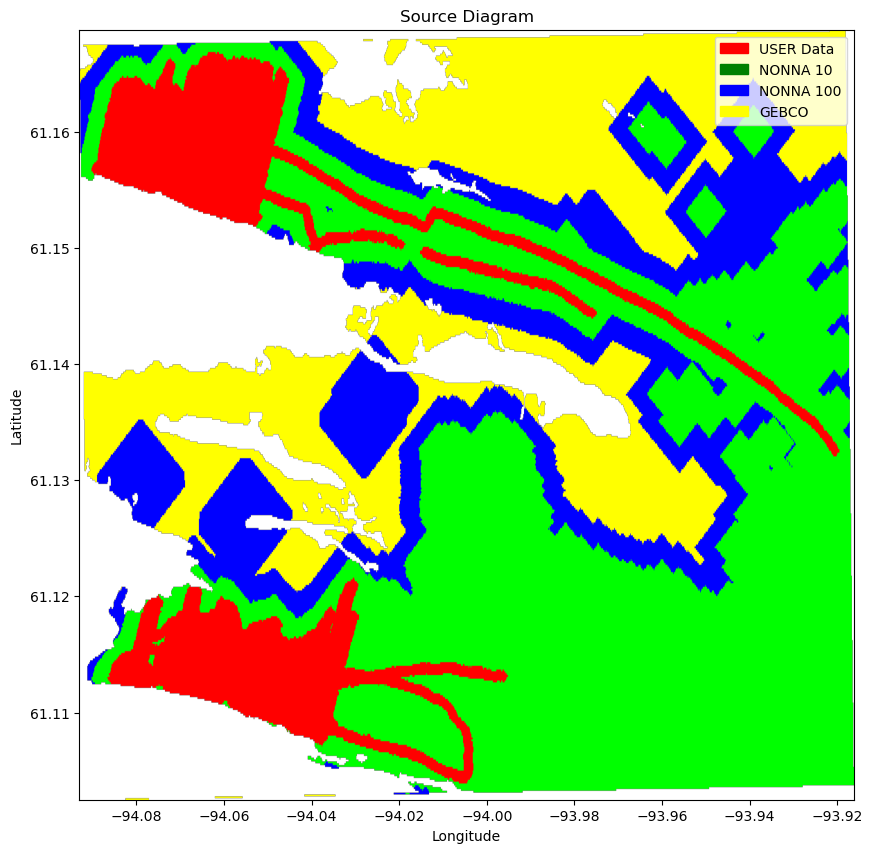

Figure Size: [10. 10.]
Aspect Ratio (expected Y stretch): auto
Plot saved as: ./output/Bathymetric_Features/bathymetry_plot.png


In [93]:
### VISUALISATION BAND 2 IN LAYERS - PLOT

import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from matplotlib.patches import Patch

# Define file paths
input_tiff = "./output/Bathymetric_Features/merged_bathymetry_10_100_gebco.tif"
reprojected_tiff = "./output/Bathymetric_Features/reprojected_merged_bathymetry_10_100_gebco_4326.tif"
clip_geojson = "./output/Chart_Features/chartlimit_utm.geojson"
clipped_tiff = "./output/Bathymetric_Features/clipped_gebco.tif"
output_image = "./output/Bathymetric_Features/bathymetry_plot.png"

# Step 1: Reproject the Raster to EPSG:4326 (Preserve NoData)
def reproject_raster(input_tif, output_tif, dst_crs="EPSG:4326"):
    with rasterio.open(input_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        nodata_value = src.nodata

        new_meta = src.meta.copy()
        new_meta.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "nodata": nodata_value,
            "compress": "deflate"  # Use "lzw" or "jpeg" for other cases
        })

        with rasterio.open(output_tif, "w", **new_meta) as dst:
            band2_reprojected = np.full((height, width), nodata_value, dtype=np.float32)

            reproject(
                source=rasterio.band(src, 2),
                destination=band2_reprojected,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
                dst_nodata=nodata_value
            )

            dst.write(band2_reprojected, 1)

    print(f"Reprojected raster saved as: {output_tif}")

# Step 2: Clip the Raster Using Boundary
def clip_raster(input_tif, clip_geojson, output_tif):
    clip_boundary = gpd.read_file(clip_geojson)

    with rasterio.open(input_tif) as dataset:
        raster_crs = dataset.crs
        raster_bounds = dataset.bounds

        if clip_boundary.crs != raster_crs:
            clip_boundary = clip_boundary.to_crs(raster_crs)

        clip_bounds = clip_boundary.total_bounds

        if (raster_bounds.right < clip_bounds[0] or  
            raster_bounds.left > clip_bounds[2] or   
            raster_bounds.top < clip_bounds[1] or    
            raster_bounds.bottom > clip_bounds[3]):  

            print("Warning: Clipping boundary does NOT overlap with raster! Skipping clipping.")
            return input_tif  

        else:
            clip_geometry = [geom.__geo_interface__ for geom in clip_boundary.geometry]
            clipped_data, clipped_transform = mask(dataset, clip_geometry, crop=True, nodata=nodata_value)

            clipped_data[clipped_data == dataset.nodata] = nodata_value  

            clipped_meta = dataset.meta.copy()
            clipped_meta.update({
                "driver": "GTiff",
                "height": clipped_data.shape[1],
                "width": clipped_data.shape[2],
                "transform": clipped_transform,
                "nodata": nodata_value,
                "compress": "deflate"  # Use "lzw" or "jpeg" for other cases
            })

            with rasterio.open(output_tif, "w", **clipped_meta) as dest:
                dest.write(clipped_data)

            print(f"Clipped raster saved as: {output_tif}")

    return output_tif  

# Step 3: Execute Reprojection & Clipping
reproject_raster(input_tiff, reprojected_tiff)
clipped_tiff = clip_raster(reprojected_tiff, clip_geojson, clipped_tiff)

# Step 4: Load Clipped Raster for Visualization
with rasterio.open(clipped_tiff) as dataset:
    raster_band2 = dataset.read(1)  
    nodata_value = dataset.nodata

    raster_band2 = np.where(raster_band2 == nodata_value, np.nan, raster_band2)  

    source_colors = {
        1: "red",    
        2: "green",  
        3: "blue",   
        4: "yellow"  
    }
    source_labels = {
        1: "USER Data",
        2: "NONNA 10",
        3: "NONNA 100",
        4: "GEBCO"
    }

    color_matrix = np.zeros((raster_band2.shape[0], raster_band2.shape[1], 4))  

    for key, color in source_colors.items():
        mask = (raster_band2 == key)
        if color == "red":
            color_matrix[mask] = [1, 0, 0, 1]  
        elif color == "green":
            color_matrix[mask] = [0, 1, 0, 1]  
        elif color == "blue":
            color_matrix[mask] = [0, 0, 1, 1]  
        elif color == "yellow":
            color_matrix[mask] = [1, 1, 0, 1]  

    color_matrix[np.isnan(raster_band2)] = [0, 0, 0, 0]  

# Step 5: Plot the Image with Debugging Prints
fig, ax = plt.subplots(figsize=(10, 10))  # Force a taller figure

# Get raster bounding box
x_min, x_max = dataset.bounds.left, dataset.bounds.right
y_min, y_max = dataset.bounds.bottom, dataset.bounds.top

# Compute center and adjusted Y-range
x_range = x_max - x_min  # Correct width
y_range = (y_max - y_min) # Stretch Y twice as large as X

# Debugging Prints: Check bounding values
print(f"Bounding Box Values:")
print(f"Longitude (X-axis): x_min = {x_min}, x_max = {x_max}")
print(f"Latitude (Y-axis): y_min = {y_min}, y_max = {y_max}")
print(f"Computed X-range: {x_range}")
print(f"Computed Y-range: {y_range}")

# **Force X/Y stretching manually**
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# **Force Y to be stretched 2x more than X**
ax.set_aspect(0.5, adjustable="box")  # This locks Y stretch without cropping X

# Debugging Prints: Check applied axis limits
print(f"Applied Axis Limits:")
print(f"X-axis limits: {ax.get_xlim()}")
print(f"Y-axis limits: {ax.get_ylim()}")

# Display the image with independent X and Y scaling
ax.imshow(color_matrix, extent=[x_min, x_max, y_min, y_max], aspect='auto')

ax.set_title("Source Diagram")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Step 6: Add Legend
legend_patches = [Patch(color=source_colors[k], label=source_labels[k]) for k in source_labels.keys()]
ax.legend(handles=legend_patches, loc="upper right")

# Step 7: Save and Show
plt.savefig(output_image, dpi=300, bbox_inches="tight", transparent=True)
plt.show()

# Debugging Print: Check Figure Size and Aspect
print(f"Figure Size: {fig.get_size_inches()}")
print(f"Aspect Ratio (expected Y stretch): {ax.get_aspect()}")
print(f"Plot saved as: {output_image}")
